In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.collections as mc

from pprint import pprint

from plot import *
from building import *
from config import *
from generator import *
from db_utils import *
from scanner import *
from misc_utils import *

### Assumptions

1. Every edge for every building is divided into subparts if the length is very large. For example, a stadium's edge even though it is straight, will be divided into multiple edges to make sure the edge is detected in the scanner. This is required as the scanner's range is restricted. Doing this has no performance hit as the bottleneck is the number of features in edge, so the splitting has no performance hit on ***this*** algorithm.
2. Buildings are convex. If not, split the building into convex parts and the overlapping edges with no feature points

### Algorithm

- Tag all nodes, edges based on FOV
- Find all the buildings that are there in the given FOV
    - A building is visible if either the edge is tagged in FOV or the vertex is tagged in FOV
- For all buildings get the frontier set of edges based on the ORIGIN
- Valid edges are current all edges that are tagged in FOV as well as in the frontier.
- Remove edges from this set that are overshadowed
- Calculate the effective scope of each building
- For every building scope, remove edges that are overshadowed by this scope

In [2]:
if ORIGINAL_DATA:
    points = read_points()
    edges = read_edges(points)
else:
    points = generate_data(NPOINTS)
    edges = get_edges()

print_util(points, "points")
print_util(edges, "edges")

edges_mat = get_adj_mat(points, edges)
print_util(edges_mat, "edges_mat")

edges_list = get_adj_list(points, edges)
print_util(edges_list, "edges_list")

0    culc0
1    culc1
2    culc2
3    culc3
4    culc4
Name: p1_tag, dtype: object
points
            y          x         tag  level                            desc  \
0   33.775231 -84.396620       culc0      0                   CULC Entrance   
1   33.775146 -84.396161       culc1      0                       CULC Back   
2   33.774515 -84.396166       culc2      0          CULC Library Connector   
3   33.774206 -84.396171       culc3      0          CULC Library Connector   
4   33.774151 -84.396629       culc4      0             CULC Other Entrance   
5   33.774510 -84.396068     prglib0      0    Price Gilbert Library Back 1   
6   33.774502 -84.395481     prglib1      0    Price Gilbert Library Back 2   
7   33.774198 -84.395479     prglib2      0  Price Gilbert Library Conector   
8   33.774206 -84.396075     prglib3      0  Price Gilbert Library Conector   
9   33.774352 -84.395360  crossland0      0                     Crossland 1   
10  33.774349 -84.394956  crossland2     

In [3]:
base_angle = get_angle(DIRECTION)

viewpoint = add_vector_to_point(ORIGIN, DIRECTION, RADIUS)

viewpoint_begin = rotate_point(viewpoint, ORIGIN, FOV/2)
viewpoint_end = rotate_point(viewpoint, ORIGIN, -FOV/2)

axis_xp = rotate_point(viewpoint, ORIGIN, -90)
axis_xn = rotate_point(viewpoint, ORIGIN, 90)

print("base_angle ", base_angle)
print("viewpoint ", viewpoint)
print("viewpoint_begin ", viewpoint_begin)
print("viewpoint_end ", viewpoint_end)
print("axis_xp ", axis_xp)
print("axis_xn ", axis_xn)

base_angle  45.00000000000001
viewpoint  [-84.39522332270843, 33.776479614088515]
viewpoint_begin  [-84.39682369851899, 33.777312717003994]
viewpoint_end  [-84.39439021979295, 33.774879238277954]
axis_xp  [-84.39522332270843, 33.77223697340139]
axis_xn  [-84.39946596339556, 33.776479614088515]


In [4]:
tag_points_fov(points)
print_util(points, "points")

points
            y          x         tag  level                            desc  \
0   33.775231 -84.396620       culc0      0                   CULC Entrance   
1   33.775146 -84.396161       culc1      0                       CULC Back   
2   33.774515 -84.396166       culc2      0          CULC Library Connector   
3   33.774206 -84.396171       culc3      0          CULC Library Connector   
4   33.774151 -84.396629       culc4      0             CULC Other Entrance   
5   33.774510 -84.396068     prglib0      0    Price Gilbert Library Back 1   
6   33.774502 -84.395481     prglib1      0    Price Gilbert Library Back 2   
7   33.774198 -84.395479     prglib2      0  Price Gilbert Library Conector   
8   33.774206 -84.396075     prglib3      0  Price Gilbert Library Conector   
9   33.774352 -84.395360  crossland0      0                     Crossland 1   
10  33.774349 -84.394956  crossland2      0                     Crossland 2   
11  33.774029 -84.394975  crossland3      0  

In [5]:
tag_edges_fov(points, edges)
print_util(edges)

                  tag p1_tag p2_tag direction  virtual      color  start  end
0  culc_main_entrance  culc0  culc1         N        0      black      0    1
1         culc_back_1  culc1  culc2         E        0      black      1    2
2      culc_connector  culc2  culc3         E        1  lightblue      2    3
3  culc_back_entrance  culc3  culc4         S        0  lightblue      3    4
4             culc_tg  culc4  culc0         W        0      black      4    0



In [6]:
id_to_build_map, buildings = get_building_set(points, edges_list)
print_util(id_to_build_map, "id_to_build_map")
print_util(buildings, "buildings")

id_to_build_map
{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 1,
 6: 2,
 7: 3,
 8: 4,
 9: 5,
 10: 6,
 11: 7,
 12: 8}

buildings
{0: [0, 1, 4, 3, 2],
 1: [5],
 2: [6],
 3: [7],
 4: [8],
 5: [9],
 6: [10],
 7: [11],
 8: [12]}



In [7]:
spans = get_spans(points, edges, edges_list, buildings)
print_util(spans, "spans")

[[0.0007449780985669958,
  388.8546381565265,
  4,
  -84.39662904741164,
  33.77415113379022],
 [0.0011337916234703026,
  95.29273605402969,
  0,
  -84.39662030286206,
  33.77523054069089],
 [0.001183115372030301,
  397.5871036404858,
  3,
  -84.3961714159838,
  33.77420564961636],
 [0.001189368633934191,
  52.55026682100482,
  2,
  -84.39616558628408,
  33.774514571975786],
 [0.001421469237143213,
  78.63952114211887,
  1,
  -84.3961612140093,
  33.77514573929421]]

[[0.001285653718193366,
  51.764360997364314,
  5,
  -84.39606793881381,
  33.774509726143464]]

[[0.0018696129158497514,
  49.4223998972665,
  6,
  -84.39548059656725,
  33.774502457394455]]

[[0.001872345313684596,
  400.10052434741647,
  7,
  -84.39547913914232,
  33.774198380841526]]

[[0.0012785617068258276,
  398.143252300868,
  8,
  -84.39607522593845,
  33.77420564961636]]

[[0.0019850219958372026,
  404.82516145876116,
  9,
  -84.39535963029812,
  33.77435223644345]]

[[0.0023887391201583984,
  404.7675367607404,


In [8]:
remove_overshadowing_edges(points, edges)
print_util(edges, "edges after overshadow filter")

edges after overshadow filter
                  tag p1_tag p2_tag direction  virtual      color  start  end
0  culc_main_entrance  culc0  culc1         N        0      black      0    1
1         culc_back_1  culc1  culc2         E        0  lightblue      1    2
2      culc_connector  culc2  culc3         E        1  lightblue      2    3
3  culc_back_entrance  culc3  culc4         S        0  lightblue      3    4
4             culc_tg  culc4  culc0         W        0      black      4    0



In [9]:
remove_overshadowing_edges_spans(points, edges, spans)
print_util(edges, "edges after spanned overshadow filter")

edges after spanned overshadow filter
                  tag p1_tag p2_tag direction  virtual      color  start  end
0  culc_main_entrance  culc0  culc1         N        0      black      0    1
1         culc_back_1  culc1  culc2         E        0  lightblue      1    2
2      culc_connector  culc2  culc3         E        1  lightblue      2    3
3  culc_back_entrance  culc3  culc4         S        0  lightblue      3    4
4             culc_tg  culc4  culc0         W        0      black      4    0



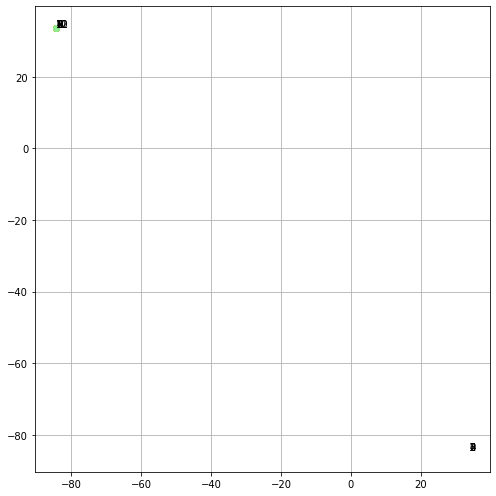

In [10]:
plot_situation(points, edges, viewpoint, viewpoint_begin, viewpoint_end, axis_xp, axis_xn)

In [11]:
points

,y,x,tag,level,desc,color,normalized_angle
0,33.775231,-84.396620,culc0,0,CULC Entrance,black,95.292736
1,33.775146,-84.396161,culc1,0,CULC Back,black,78.639521
2,33.774515,-84.396166,culc2,0,CULC Library Connector,crimson,52.550267
3,33.774206,-84.396171,culc3,0,CULC Library Connector,crimson,397.587104
4,33.774151,-84.396629,culc4,0,CULC Other Entrance,crimson,388.854638
5,33.774510,-84.396068,prglib0,0,Price Gilbert Library Back 1,crimson,51.764361
6,33.774502,-84.395481,prglib1,0,Price Gilbert Library Back 2,crimson,49.422400
7,33.774198,-84.395479,prglib2,0,Price Gilbert Library Conector,crimson,400.100524
8,33.774206,-84.396075,prglib3,0,Price Gilbert Library Conector,crimson,398.143252
9,33.774352,-84.395360,crossland0,0,Crossland 1,crimson,404.825161


<AxesSubplot:xlabel='x'>

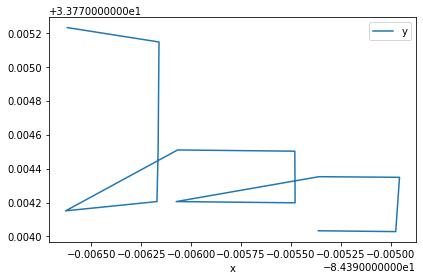

In [15]:
points.plot('x', 'y')